In [33]:
import time
import json
import cv2
import torch
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.patches as patches
from IPython import display
from torch import nn, optim
from PIL import Image
from torch.utils.data import Dataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Save the train, test data dir in a txt for model-training

In [3]:
train_txt_path = './train.txt'
test_txt_path = './test.txt'
train_1_dir = './train/train_1/'
train_0_dir = './train/train_0/'
test_1_dir = './test/test_1/'
test_0_dir = './test/test_0/'

In [4]:
def gen_txt(txt_path, img1_dir, img0_dir):
    f = open(txt_path, 'w')
    for s_dir in sorted(os.listdir(img1_dir)):
        i_dir = os.path.join(img1_dir, s_dir)
        '''
        if i_dir.split('_')[2] == '0':
            line = i_dir + ' ' + '0' + '\n'
        else:
        '''
        line = i_dir + ' ' + '1' + '\n'
        f.write(line)
    for s_dir in sorted(os.listdir(img0_dir)):
        i_dir = os.path.join(img0_dir, s_dir)
        '''
        if i_dir.split('_')[2] == '0':
            line = i_dir + ' ' + '0' + '\n'
        else:
        '''
        line = i_dir + ' ' + '0' + '\n'
        f.write(line)
        
    f.close()

In [5]:
gen_txt(train_txt_path, train_1_dir, train_0_dir)
gen_txt(test_txt_path, test_1_dir, test_0_dir)

## Load Dataset

In [13]:
class MyDataset(Dataset):
    def __init__(self, txt_path, transform = None, target_transform = None):
        fh = open(txt_path, 'r')
        imgs = []
        for line in fh:
            line = line.rstrip()
            words = line.split()
            imgs.append((words[0], int(words[1])))
            self.imgs = imgs 
            self.transform = transform
            self.target_transform = target_transform

    def __getitem__(self, index):
        fn, label = self.imgs[index]
        #img = Image.open(fn).convert('RGB') 
        img = Image.open(fn)
        #if img.mode != 'L':
            #img = img.convert('L')
        if self.transform is not None:
            img = self.transform(img) 
        return img, label
        
    def __len__(self):
        return len(self.imgs)

## Mean and standard deviations

In [14]:
def getStat(train_data):
    print('Compute mean and variance for training data.')
    print(len(train_data))
    train_loader = torch.utils.data.DataLoader(
        train_data, batch_size=1, shuffle=False, num_workers=0,
        pin_memory=True)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    for X, _ in train_loader:
        for d in range(3):
            mean[d] += X[:, d, :, :].mean()
            std[d] += X[:, d, :, :].std()
    mean.div_(len(train_data))
    std.div_(len(train_data))
    return list(mean.numpy()), list(std.numpy())

In [15]:
train_pipline = torchvision.transforms.Compose([
    #transforms.RandomHorizontalFlip(),
    #transforms.Resize((227,227)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

valid_pipline = torchvision.transforms.Compose([
    #transforms.RandomHorizontalFlip(),
    #transforms.Resize((227,227)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_pipline = torchvision.transforms.Compose([
    #transforms.RandomHorizontalFlip(),
    #transforms.Resize((227,227)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = MyDataset('./train.txt', transform=train_pipline)
valid_data = MyDataset('./test.txt', transform=valid_pipline)
#test_data = MyDataset('./test.txt', transform=test_pipline)


trainloader = torch.utils.data.DataLoader(dataset=train_data, batch_size=64, shuffle=True)
validloader = torch.utils.data.DataLoader(dataset=valid_data, batch_size=64, shuffle=True)
#testloader = torch.utils.data.DataLoader(dataset=test_data, batch_size=32, shuffle=False)

classes = (0, 1)

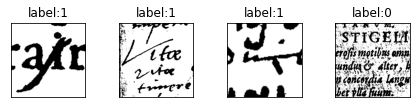

In [16]:
# show some examples of data
examples = enumerate(trainloader)
batch_idx, (example_data, example_label) = next(examples)
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.tight_layout() 
    img = example_data[i]
    img = img.numpy() 
    img = np.transpose(img, (1,2,0)) 
    img = img * [0.5, 0.5, 0.5] + [0.5, 0.5, 0.5]
    plt.imshow(img, 'gray')
    plt.title("label:{}".format(example_label[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

## Model

In [18]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=1):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 500),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(500, 20),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(20, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

## Setting Hyperparameters

In [19]:
num_classes = 2
num_epochs = 5
batch_size = 64
learning_rate = 0.005

model = AlexNet(num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  


## Train

In [22]:
total_step = len(trainloader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainloader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            
    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in validloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
    
        print('Accuracy of the network on the {} validation images: {} %'.format(1000, 100 * correct / total)) 

    

Epoch [1/5], Step [97/97], Loss: 0.2102
Accuracy of the network on the 1000 validation images: 85.3395061728395 %
Epoch [2/5], Step [97/97], Loss: 0.0715
Accuracy of the network on the 1000 validation images: 89.35185185185185 %
Epoch [3/5], Step [97/97], Loss: 0.0873
Accuracy of the network on the 1000 validation images: 89.04320987654322 %
Epoch [4/5], Step [97/97], Loss: 0.0725
Accuracy of the network on the 1000 validation images: 89.19753086419753 %
Epoch [5/5], Step [97/97], Loss: 0.2451
Accuracy of the network on the 1000 validation images: 90.74074074074075 %


In [25]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        #del images, labels, outputs

    print('Accuracy of the network on the {} test images: {} %'.format(1000, 100 * correct / total))   

Accuracy of the network on the 10000 test images: 90.48582995951416 %


In [26]:
# save model
torch.save(model, './new-alexnet-test.pth')

In [28]:
with open ('test_coordinates.json') as f:
    test_coordinates = json.load(f)

## Test on images

In [4]:
with open ('test_0_coordinates.json') as f:
    test = json.load(f)

with open ('train_0_coordinates.json') as f:
    train = json.load(f)

prediction = {}
prediction.update(test)
prediction.update(train)

In [11]:
def cut_image(path1, path2, p, prediction, cut, file):
    for j in p:
        i = j.split('.')[0]
        img_path = path1+'/'+i+'.png'
        im = cv2.imread(img_path)
    
        a = 0
        for j in prediction[str(i)]:
            if j[3] > 60 and j[2] > 60:
                b, c = j[1]+j[3], j[0]+j[2]
                if j[1] < 0:
                    j[1] = 0
                if j[0] < 0:
                    j[0] = 0
                name = i+'_'+str(a)
                b, c = j[1]+j[3], j[0]+j[2]
                ims = im[j[1]:b, j[0]:c]
                cut[name] = [int(j[2]), int(j[3])]
                cv2.imwrite(path2+name+'.png', ims)
            a += 1

    with open(file, 'w') as f:
        json.dump(cut, f)

In [12]:
p_list = sorted(os.listdir('./prediction/image/'))
cut = {}
cut_image('./prediction/image/', './prediction/cut/', p_list, prediction, cut, 'predict_cut_shape.json')

In [13]:
with open ('predict_cut_shape.json') as f:
    shape = json.load(f)

In [14]:
def pre_data(path1, path2, j):
    img = cv2.imread(path1+j+'.png')
    kernel = np.ones((2, 2), np.uint8)
    opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    #closing = cv2.morphologyEx(threshold, cv2.MORPH_CLOSE, kernel)
    if (opening.shape[0]>=opening.shape[1] and (opening.shape[0]/opening.shape[1])<=2.1) or (opening.shape[0]<=opening.shape[1] and (opening.shape[1]/opening.shape[0])<=2.1):
        resized_image = cv2.resize(opening, (227, 227))
        cv2.imwrite(path2+j+'_'+'.png', resized_image)
    elif opening.shape[0]>opening.shape[1] and (opening.shape[0]/opening.shape[1])>2.1:
        n = int(opening.shape[0] / opening.shape[1])
        dis_h = int(np.floor(opening.shape[0] / n))
        for i in range(n):
            a = i+1
            sub = opening[i*dis_h:(i+1)*dis_h, 0:opening.shape[1]]
            resized_image = cv2.resize(sub, (227, 227))
            cv2.imwrite(path2+j+'_'+str(a)+'.png', resized_image)
    elif opening.shape[0]<opening.shape[1] and (opening.shape[1]/opening.shape[0])>2.1:
        n = int(opening.shape[1] / opening.shape[0])
        dis_w = int(np.floor(opening.shape[1] / n))
        for i in range(n):
            a = i+1
            sub = opening[0:opening.shape[0], i*dis_w:(i+1)*dis_w]
            resized_image = cv2.resize(sub, (227, 227))
            cv2.imwrite(path2+j+'_'+str(a)+'.png', resized_image)
    #print(j)

In [ ]:
for j in shape.keys():
    pre_data('./prediction/cut/', './prediction/final/', j)

In [22]:
model = torch.load('./new-alexnet-test.pth') 
model = model.to(device)
model.eval()

test_data = {}
data_path = './prediction/final/'
for s_dir in sorted(os.listdir(data_path)):
    img = Image.open(data_path+s_dir) 
    #if img.mode != 'L':
        #img = img.convert('L')

    trans = torchvision.transforms.Compose(
        [
            #torchvision.transforms.Resize((227,227)),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    img = trans(img)
    img = img.to(device)
    img = img.unsqueeze(0) 

    classes = ('0', '1')
    output = model(img)
    prob = F.softmax(output, dim=1) 
    print("Probability: ",prob)
    value, predicted = torch.max(output.data, 1)
    predict = output.argmax(dim=1)
    pred_class = classes[predicted.item()]
    print("Prediction: ",pred_class)
    test_data[s_dir.split('.')[0]] = pred_class

Probability:  tensor([[0.9233, 0.0767]], grad_fn=<SoftmaxBackward0>)
Prediction:  0
Probability:  tensor([[0.9537, 0.0463]], grad_fn=<SoftmaxBackward0>)
Prediction:  0
Probability:  tensor([[0.9825, 0.0175]], grad_fn=<SoftmaxBackward0>)
Prediction:  0
Probability:  tensor([[0.9949, 0.0051]], grad_fn=<SoftmaxBackward0>)
Prediction:  0
Probability:  tensor([[0.9875, 0.0125]], grad_fn=<SoftmaxBackward0>)
Prediction:  0
Probability:  tensor([[0.9965, 0.0035]], grad_fn=<SoftmaxBackward0>)
Prediction:  0
Probability:  tensor([[0.9653, 0.0347]], grad_fn=<SoftmaxBackward0>)
Prediction:  0
Probability:  tensor([[0.0379, 0.9621]], grad_fn=<SoftmaxBackward0>)
Prediction:  1
Probability:  tensor([[0.9324, 0.0676]], grad_fn=<SoftmaxBackward0>)
Prediction:  0
Probability:  tensor([[0.9898, 0.0102]], grad_fn=<SoftmaxBackward0>)
Prediction:  0
Probability:  tensor([[0.9866, 0.0134]], grad_fn=<SoftmaxBackward0>)
Prediction:  0
Probability:  tensor([[0.9780, 0.0220]], grad_fn=<SoftmaxBackward0>)
Predict

In [24]:
l = []
for i in test_data.keys():
    if test_data[i] == '1':
        print(i)
        l.append(i)

184145_105_
184145_19_3
184145_19_5
184145_19_6
184145_3_1
184145_3_2
184257_140_
184257_47_
184415_100_1
184415_33_
184415_35_
184415_38_
184415_40_
184415_46_1
184415_46_2
184415_46_3
184415_56_
184415_57_
184415_61_1
184415_61_2
184415_69_
184415_70_1
184415_86_1
184426_23_2
184426_23_4
184426_24_2
184426_4_1
184426_4_2
184550_25_2
184550_41_
184550_5_2
186510_163_
186510_19_3
186510_40_
186510_61_1
186537_17_
186542_14_1
186542_14_2
186542_24_1
186542_24_2
186542_25_1
186542_25_2
186542_30_
186542_33_
186542_35_1
186542_35_2
186546_113_
186546_231_
186546_29_
186546_37_3
186546_99_
186762_108_
186762_11_
186762_127_
186762_14_2
186762_15_4
186762_173_
186762_36_2
186762_36_3
186762_39_2
186762_52_1
186762_52_2
186762_52_3
186762_52_4
186762_82_
186762_96_
187548_102_1
187548_122_
187548_19_2
187548_23_2
187548_32_3
187548_40_2
187599_2_
187599_5_
188929_39_1
188929_39_2
188929_45_
188929_5_2
188929_66_
188929_6_
188929_7_
188929_9_2
188941_12_2
188941_15_1
188941_20_2
188941_23_1
1

In [29]:
result = {}
for i in sorted(os.listdir('./prediction/image/')):
    result[i.split('.')[0]] = []

for j in l:
    i = j.split('_')[0]
    k = int(j.split('_')[1])
    result[i].append(prediction[i][k])

with open('result.json', 'w') as f:
        json.dump(result, f)

In [35]:
def plot_box(id, l1, l2):
    image = cv2.imread('./b_w_image/'+id+'.png')
    for i in l1:
        image = cv2.rectangle(image, (i[0], i[1]), (i[0]+i[2], i[1]+i[3]), (0, 0, 255), thickness=2)
    for i in l2:
        image = cv2.rectangle(image, (int(i[0]), int(i[1])), (int(i[2]), int(i[3])), (0, 255, 0), thickness=2)

    cv2.imwrite('./result/'+id+'.png', image)


In [31]:
with open ('result.json') as f:
    result = json.load(f)

handwritten = pd.read_csv('data.csv') 

In [36]:
for j in sorted(os.listdir('./prediction/image/')):
    i = j.split('.')[0]
    list1 = []
    for k in range(len(handwritten[handwritten['number']==int(i)])):
        list1.append([list(handwritten[handwritten['number']==int(i)]['xmin'])[k], list(handwritten[handwritten['number']==int(i)]['ymin'])[k], list(handwritten[handwritten['number']==int(i)]['xmax'])[k], list(handwritten[handwritten['number']==int(i)]['ymax'])[k]])
    plot_box(i, result[i], list1)
    #print(list1)